In [1]:
import numpy as np
from binomial import Binomial
from calibration import calibration
from rcn import rcn
import statsmodels.formula.api as smf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from tqdm import tqdm

Interest rate  -0.0078
Dividend yield 0.0023
------------------------------
Minimum found!
Func value     1.0032
Up             1.0550
Down           0.9437
------------------------------
               simc      Call         simp       Put
Strike                                              
12000    381.368573   381.525  1662.509192  1662.321
11800    420.441757   420.599  1500.015927  1499.822
11600    493.136059   493.332  1371.143781  1370.990
11400    571.184005   571.380  1247.625279  1247.470
11200    649.231952   649.428  1124.106776  1123.951
11000    727.279898   727.476  1000.588274  1000.440
10800    805.327844   805.524   877.069772   876.917
10600    883.375790   883.572   753.551269   753.399
10400    991.168881   991.344   659.777912   659.605
10200   1114.687383  1114.862   581.729966   581.557
10000   1238.205886  1238.381   503.682019   503.509
9800    1361.724388  1361.900   425.634073   425.461
9600    1485.242891  1485.422   347.586127   347.413
9400    1612.6791

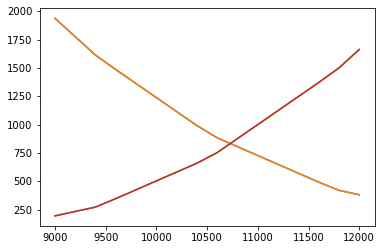

In [2]:
"""Run callibration file and return the interest rate, div yield, u and d"""
r, y, u, d = calibration()

## Question 1

In [3]:
T = 12
dt = 1/T
i0 = 11118
c = 0.1
alpha = 1
beta = 0.8

In [4]:

tree = Binomial(r, T, dt, i0, u, d, y)

print('{:10} : {:.4f}'.format(' rcn', tree.price_RCN(alpha, c)))
print('{:10} : {:.4f}'.format('brcn', tree.price_RCN(alpha, c, beta)))
print('{:10} : {:.4f}'.format('bond', tree.price_bond(c*dt)))

print()
note = rcn(r, dt, i0, y, u, d, c, T)
print('{:10} : {:.4f}'.format(' rcn', note.price_rcn(alpha=alpha, c=c)))
print('{:10} : {:.4f}'.format('brcn', note.price_brcn(alpha=alpha, beta=beta, c=c)))
print('{:10} : {:.4f}'.format('bond', note.bond))


 rcn       : 1.0117
brcn       : 1.0542
bond       : 1.1083

 rcn       : 1.0117
brcn       : 1.0542
bond       : 1.1083


## Question 2

In [5]:
par_price = 1

def f(c, *args):
    alpha, beta, type = args
    if type == 'RCN': p = tree.price_RCN(alpha, c)
    if type == 'BRCN': p = tree.price_RCN(alpha, c, beta)
    return (par_price - p) ** 2

res_RCN = minimize(f, 0, args=(alpha, beta, 'RCN'))
res_BRCN = minimize(f, 0, args=(alpha, beta, 'BRCN'))
print('alpha = {}, beta = {}'.format(alpha, beta))
if res_RCN.success: print('Par coupon for RCN:  c = {:.2%}'.format(res_RCN.x[0]))
if res_BRCN.success: print('Par coupon for BRCN: c = {:.2%}'.format(res_BRCN.x[0]))

alpha = 1, beta = 0.8
Par coupon for RCN:  c = 8.83%
Par coupon for BRCN: c = 4.61%


In [6]:
res_RCN = minimize(f, 0, args=(alpha, beta, 'RCN'))
rates = [0.4,0.6,0.8,1]
alphas = np.linspace(0.6, 1, 10)
betas = np.outer(alphas, rates)

rcn_c = []
brcn_c = np.zeros_like(betas)

for i, b in enumerate(betas):
    alpha = alphas[i]
    res_RCN = minimize(f, 0, args=(alpha, beta, 'RCN'))
    rcn_c.append(res_RCN.x[0]*100)
    for j, beta in enumerate(b):
        res_BRCN = minimize(f, 0, args=(alpha, beta, 'BRCN'))
        brcn_c[i,j] = res_BRCN.x[0]*100

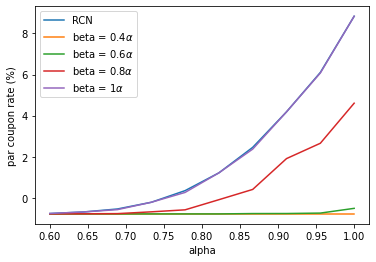

In [7]:
plt.plot(alphas, rcn_c)
for c in brcn_c.T:
    plt.plot(alphas, c)
plt.xlabel('alpha')
plt.ylabel('par coupon rate (%)')
plt.legend(['RCN'] + [r'beta = {}$\alpha$'.format(r) for r in rates])
plt.show()

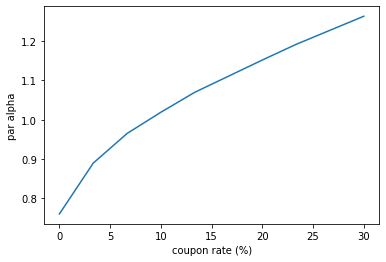

In [8]:
coupons = np.linspace(0, 0.30, 10)
par_price = 1

def g(alpha, *args):
    c, = args
    return (par_price - tree.price_RCN(alpha, c)) ** 2

alphas = []
for c in coupons:
    res = minimize(g, 1, args=(c))
    alphas.append(res.x[0])

plt.plot(coupons*100, alphas)
plt.xlabel('coupon rate (%)')
plt.ylabel('par alpha')
plt.show(tree.price_RCN(alpha, c))

In [9]:
def h(alpha, *args):
    c, rate = args
    return (par_price - tree.price_RCN(alpha, c, rate*alpha)) ** 2


coupons = np.linspace(0, 0.30, 10)
rates = [0.4, 0.6, 0.8, 1]
#betas = np.outer(coupons, rates)

cons = ({'type': 'ineq', 'fun': lambda x: 1 - x},
        {'type': 'ineq', 'fun': lambda x: x - 0.5})

brcn_alpha = []

for i, r in enumerate(rates):
    row= []
    for j, c in enumerate(tqdm(coupons)):
        c = coupons[j]
        if r==0.4 or r==0.6:
            start = 0.95
        else:
            start=0.8
        res_BRCN = minimize(h, start, args=(c, r))
        row.append(res_BRCN.x[0])
        #print(res_BRCN.x[0])
    # print(row)
    brcn_alpha.append(row)
# print(brcn_alpha)

100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


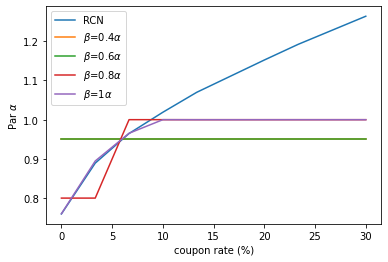

In [10]:
plt.plot(coupons*100, alphas, label='RCN')

for i, r in enumerate(rates):
    plt.plot(coupons*100, brcn_alpha[i], label=r'$\beta$={}$\alpha$'.format(r))
    plt.xlabel('coupon rate (%)')
    plt.ylabel(r'Par $\alpha$')

plt.legend()
plt.show()

#Q6-7-8

In [11]:
dates = [i for i in range(int(T/dt)+1)]
alpha = 1
c = 0.1
beta = 0.8
dates = [j for j in range(1, T)]
RCN = note.price_rcn(alpha=alpha, c=c, dates=dates)
BRCN = note.price_brcn(alpha=alpha, c=c, beta=0.8, dates=dates)
print('Price of callable simple RCN {:.4f}\nPrice of callable barrier RCN {:.4f}'.format(RCN, BRCN))

Price of callable simple RCN 0.9920
Price of callable barrier RCN 1.0008


In [12]:
par_price = 1

def f(c, *args):
    alpha, beta, type, dates = args
    if type == 'RCN': p = note.price_rcn(alpha, c, dates)
    if type == 'BRCN': p = note.price_brcn(alpha, beta, c, dates)
    return (par_price - p) ** 2

cons = ({'type': 'ineq', 'fun': lambda x: 1 - x},
        {'type': 'ineq', 'fun': lambda x: x })


rates = [0.4,0.6,0.8,1]
alphas = np.linspace(0.6, 1, 10)
betas = np.outer(alphas, rates)

rcn_c = []
brcn_c = np.zeros_like(betas)

for i, b in enumerate(tqdm(betas)):
    alpha = alphas[i]
    res_RCN = minimize(f, 0, args=(alpha, beta, 'RCN', dates), constraints=cons)
    rcn_c.append(res_RCN.x[0]*100)
    for j, beta in enumerate(b):
        res_BRCN = minimize(f, 0, args=(alpha, beta, 'BRCN', dates), constraints=cons)
        brcn_c[i,j] = res_BRCN.x[0]*100

100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


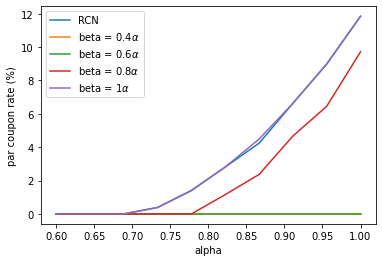

In [13]:
plt.plot(alphas, rcn_c)
for c in brcn_c.T:
    plt.plot(alphas, c)
plt.xlabel('alpha')
plt.ylabel('par coupon rate (%)')
plt.legend(['RCN'] + [r'beta = {}$\alpha$'.format(r) for r in rates])
plt.show()

In [14]:
def h(alpha, *args):
    c, r, type, dates = args
    if type == 'RCN': p = note.price_rcn(alpha, c, dates)
    if type == 'BRCN': p = note.price_brcn(alpha, r*alpha, c, dates)
    return (par_price - p) ** 2


coupons = np.linspace(0, 0.30, 15)
rates = [0.4, 0.6, 0.8, 1]
#betas = np.outer(coupons, rates)

cons = ({'type': 'ineq', 'fun': lambda x: 1 - x},
        {'type': 'ineq', 'fun': lambda x: x - 0.5})

brcn_alpha = []

for i, r in enumerate(rates):
    row= []
    for j, c in enumerate(tqdm(coupons)):
        c = coupons[j]
        if r==0.4 or r==0.6:
            start = 0.9
        else:
            start=0.5
        res_BRCN = minimize(h, start, args=(c, r, 'BRCN', dates), constraints=cons)
        row.append(res_BRCN.x[0])
        #print(res_BRCN.x[0])
    # print(row)
    brcn_alpha.append(row)
# print(brcn_alpha)

100%|██████████| 15/15 [00:01<00:00, 11.42it/s]


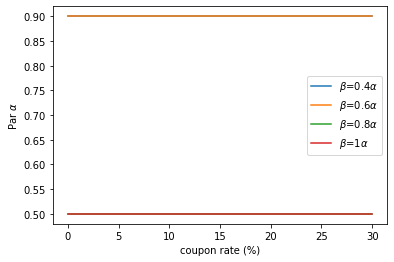

In [15]:
for i, r in enumerate(rates):
    plt.plot(coupons*100, brcn_alpha[i], label=r'$\beta$={}$\alpha$'.format(r))
    plt.xlabel('coupon rate (%)')
    plt.ylabel(r'Par $\alpha$')

plt.legend()
plt.show()



